# <font color=blue>*Natural language Processing Applications - Example Codes*</font> 

# *Chapter-4: Text Classification* 
## This notebook aims to give you a brief overview of performing text classification using Naive Bayes and Logistic Regression.

We will be using a dataset called "Economic news article tone and relevance" from Figure-Eight (https://www.figure-eight.com/data-for-everyone/) which consists of approximately 8000 news articles, which were tagged as relevant or not relevant to the US Economy. Our goal in this notebook is to explore the process of training and testing text classifiers for this problem, using this data set and two text classification algorithms: Multinomial Naive Bayes and Logistic Regression, implemented in sklearn. 

##### Dataset Link: https://d1p17r2m4rzlbo.cloudfront.net/wp-content/uploads/2016/03/Full-Economic-News-DFE-839861.csv

Let's import few necessary packages before we start our work. 

In [116]:
import pandas as pd
from collections import Counter
from sklearn.metrics import confusion_matrix 
import matplotlib as mpl 
import matplotlib.cm as cm 
import matplotlib.pyplot as plt 
import pandas as pd 
import nltk
import re
import csv
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import train_test_split
from time import time

### Section 1: Load and explore the dataset

In [117]:
our_data = pd.read_csv("/home/bangaru/Downloads/NLPBookTut/Full-Economic-News-DFE-839861.csv", encoding = "ISO-8859-1")


In [118]:
our_data.head() #We need columns: relevance and text to do text classification

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,positivity,positivity:confidence,relevance,relevance:confidence,articleid,date,headline,positivity_gold,relevance_gold,text
0,842613455,False,finalized,3,12/5/15 17:48,3.0,0.6400,yes,0.640,wsj_398217788,8/14/91,Yields on CDs Fell in the Latest Week,NaN,NaN,NEW YORK -- Yields on most certificates of dep...
1,842613456,False,finalized,3,12/5/15 16:54,NaN,NaN,no,1.000,wsj_399019502,8/21/07,The Morning Brief: White House Seeks to Limit ...,NaN,NaN,The Wall Street Journal Online</br></br>The Mo...
2,842613457,False,finalized,3,12/5/15 1:59,NaN,NaN,no,1.000,wsj_398284048,11/14/91,Banking Bill Negotiators Set Compromise --- Pl...,NaN,NaN,WASHINGTON -- In an effort to achieve banking ...
3,842613458,False,finalized,3,12/5/15 2:19,NaN,0.0000,no,0.675,wsj_397959018,6/16/86,Manager's Journal: Sniffing Out Drug Abusers I...,NaN,NaN,The statistics on the enormous costs of employ...
4,842613459,False,finalized,3,12/5/15 17:48,3.0,0.3257,yes,0.640,wsj_398838054,10/4/02,Currency Trading: Dollar Remains in Tight Rang...,NaN,NaN,NEW YORK -- Indecision marked the dollar's ton...


In [119]:
our_data.shape #Number of rows (instances) and columns in the dataset

(8000, 15)

In [120]:
our_data["relevance"].value_counts()/our_data.shape[0] #Class distribution in the dataset

no          0.821375
yes         0.177500
not sure    0.001125
Name: relevance, dtype: float64

There is an imbalance in the data with *Not Relevance* being 82% in the dataset. We should keep this in mind when interpreting the classifier performance later. Let us first convert the class labels into binary outcome variables for convenience. 1 for Yes, and 0 for No, and ignore "Not sure". 

In [121]:
# convert label to a numerical variable
our_data = our_data[our_data.relevance != "not sure"]
our_data.shape
our_data['relevance'] = our_data.relevance.map({'yes':1, 'no':0}) #relevant is 1, not-relevant is 0. 
our_data = our_data[["text","relevance"]] #Let us take only the two columns we need.
our_data.shape

(7991, 2)

### Section 3: Text Pre-processing

Typical steps involve tokenization, lower casing, removing, stop words, punctuation markers etc, and vectorization. 

In [122]:
stop = set(stopwords.words('english'))
def clean(doc):
    doc = " ".join([i.replace('*', '') for i in doc.lower().split()])
    doc = " ".join([i.replace(':', ' ') for i in doc.split()])
    doc = " ".join([i.replace('.', ' ') for i in doc.split()])
    doc = " ".join([i.replace('=', '') for i in doc.split()])
    doc = " ".join([i.replace('/', ' ') for i in doc.split()])
    doc = " ".join([i.replace(')', ' ') for i in doc.split()])
    doc = " ".join([i.replace('(', ' ') for i in doc.split()])
    doc = " ".join([i.replace('"', ' ') for i in doc.split()])
    doc = " ".join([i.replace('-', ' ') for i in doc.split()])
    doc = " ".join([i.replace('_', ' ') for i in doc.split()])
    doc = " ".join([i for i in doc.split() if not i.isdigit()])
    doc = " ".join([i for i in doc.split() if i.isalpha()])
    doc = " ".join([i for i in doc.split() if i not in stop])
    doc = doc.replace("</br>", " ")
    return doc

In [123]:
our_data_texts = our_data['text'].tolist()
our_data_texts_cleaned = [clean(doc) for doc in our_data_texts]
our_data_texts_cleaned[5]

'stocks investors weighed slower expected domestic economic growth continued euro zone concerns signs federal reserve may take new steps bolster economy dow jones industrial average fell lowest close since oct downside dropped bank fell hewlett packard dropped technology company issued downbeat earnings outlook current quarter next fiscal year stock index fell nasdaq composite lost'

#### Map this clean text in the same dataframe, for that we have created a new column named clean_text.

In [124]:
our_data['text']= our_data_texts_cleaned
our_data.head()

,text,relevance
0,new york yields certificates deposit offered m...,1
1,wall street journal morning look biggest email...,0
2,washington effort achieve banking senate negot...,0
3,statistics enormous costs employee drug abuse ...,0
4,new york indecision marked traders paused awai...,1


### Section 3: Text Pre-processing

#### Now we are ready for the modelling. We are going to use algorithms from sklearn package:

#### Background of train/test split

* Train/test split is for model evaluation
* Model evaluation is to simulate the future
* Past data is exchangeable for future data
* We pretend some of our past data is coming into our future data
* By training, predicting and evaluating the data, we can check the performance of our model

#### Vectorize then split

* If we vectorize then we train/test split, our document-term matrix would contain every single feature (word) in the test and training sets
* What we want is to simulate the real world
* We would always see words we have not seen before so this method is not realistic and we cannot properly evaluate our models

#### Split then vectorize (correct way)

* We do the train/test split before the CountVectorizer to properly simulate the real world where our future data contains words * we have not seen before
* After you train your data and chose the best model, you would then train on all of your data before predicting actual future data to maximize learning.

In [125]:
# how to define X and y (from the mail spam data) for use with COUNTVECTORIZER
X = our_data.text
y = our_data.relevance
print(X.shape)
print(y.shape)

(7991,)
(7991,)


In [126]:
# split X and y into training and testing sets
# by default, it splits 75% training and 25% test
# random_state=1 for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(5993,)
(1998,)
(5993,)
(1998,)


<font color=blue>**CountVectorizer**</font> converts the given text into lower case, extract tokens, remove stop words and builts the Vocabulary which helps to encode the new text data.It usually works in three steps: 
* Creating an instance of CountVectorizer class.
<br>
* Fit this instance on our data, this step is responsible to create the vocabulary. 
<br>
* transform() function is reponsible to do the encoding. 

We can combine the step two and three into a single step as done below.

In [130]:
vect = CountVectorizer() #Step-1
X_train_dtm = vect.fit_transform(X_train)#combined step 2 and 3
X_train_dtm.shape
#transform testing data (using fitted vocabulary) into a document-term matrix
X_test_dtm = vect.transform(X_test)
X_test_dtm.shape

(1998, 31785)

#### The multinomial Naive Bayes classifier is suitable for classification with discrete features (e.g., word counts for text classification). The multinomial distribution normally requires integer feature counts. However, in practice, fractional counts such as tf-idf may also work.

In [131]:
nb = MultinomialNB() #instantiate a Multinomial Naive Bayes model
%time nb.fit(X_train_dtm, y_train)#train the model(timing it with an IPython "magic command")
y_pred_class = nb.predict(X_test_dtm)#make class predictions for X_test_dtm
metrics.accuracy_score(y_test, y_pred_class)
# examine class distribution
print(y_test.value_counts())
# there is a majority class of 0 here, hence the classes are skewed

# calculate null accuracy (for multi-class classification problems)
# .head(1) assesses the value 1208
null_accuracy = y_test.value_counts().head(1) / len(y_test)
print('Null accuracy:', null_accuracy)

CPU times: user 10.3 ms, sys: 4.22 ms, total: 14.5 ms
Wall time: 12.7 ms
0    1656
1     342
Name: relevance, dtype: int64
Null accuracy: 0    0.828829
Name: relevance, dtype: float64


### Plot the Confusion Matrix 

In [132]:
# Function to plot confusion matrix. 
# Ref:http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontsize=15)
    plt.xlabel('Predicted label',fontsize=15)

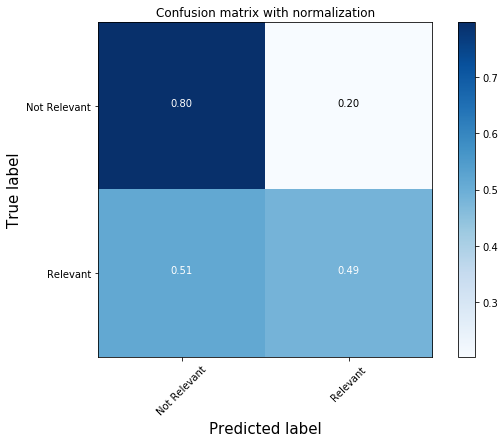

In [133]:
# print the confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=['Not Relevant','Relevant'],normalize=True,
                      title='Confusion matrix with normalization')

#### Area under the curve(AUC) gives idea about the model efficiency:
we can use this to compare to different models to benchmark their performance

Further information: https://en.wikipedia.org/wiki/Receiver_operating_characteristic

In [134]:
# calculate AUC
y_pred_prob = nb.predict_proba(X_test_dtm)[:, 1]
metrics.roc_auc_score(y_test, y_pred_prob)

0.7199021103483346

### let's try another model and see if the accuracy changes or there is any change to the AUC, for experiment we have considered logistic regression.

In [135]:
from sklearn.linear_model import LogisticRegression #import

logreg = LogisticRegression(class_weight="balanced") #instantiate a logistic regression model
logreg.fit(X_train_dtm, y_train) #fit the model with training data

#Make predictions on test data
y_pred_class = logreg.predict(X_test_dtm)

#calculate evaluation measures:
print("Accuracy: ", metrics.accuracy_score(y_test, y_pred_class))
print("AUC: ", metrics.roc_auc_score(y_test, y_pred_prob))
cnf_matrix = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=['Not Relevant','Relevant'],normalize=True,
                      title='Confusion matrix with normalization')

SyntaxError: invalid syntax (<ipython-input-135-39442c3f8c1e>, line 11)